The purpose of this notebook is to compare OpenDrift and OceanParcels drift trajectory outputs.
* I copied model inputs, initial positions and OpenDrift outputs from runs_20200910-20200912_iSphere_N24/runs/stle500_od_2020091012_P1D
  * data was copied into '/home/nso001/data/work7/OPP/DriftEval-portmodels/st-lawrence/ocean-parcels-compare' on gpsc 
  * This run had one iSPhere drifter released on 2020-09-10 at 1200.
  * The windage was 4.457053588273564
* Plan is to reproduce the trajectories with OceanParcels using the same STLE500 currents and mshydro winds that were used to force the original OpenDrift run.
* I will reproduce the same drift run parameters (timestep=60s, runge-kutta4 advection)
* Small differences between OceanParcels and OpenDrift are expected and could be explained by interpolation. Large differences would be concerning.

In [1]:
from parcels import FieldSet, ParticleSet, JITParticle, AdvectionRK4, ScipyParticle
from glob import glob
from datetime import timedelta as delta
import datetime

import glob
import os

import xarray as xr
import matplotlib.pyplot as plt
import yaml

import numpy as np
import cartopy.crs as ccrs

In [2]:
run_dir='/home/soontiensn/data/gpsc-work7/OPP/DriftEval-portmodels/saint-john/ocean-parcels-compare/'
positions_file = os.path.join(run_dir, 'original', 'drifter_positions.yaml')

ocean_dir = os.path.join(run_dir, 'original', 'ocean')
atmos_dir = os.path.join(run_dir, 'original', 'atmos')
mesh = os.path.join(run_dir, 'original', 'mesh.nc')

In [3]:
with open(positions_file, 'r') as f:
    positions=yaml.load(f, Loader=yaml.FullLoader)
positions = positions['drifter_grid_positions']
lons = []
lats = []
for key in positions:
    lon,lat,_,datestr = positions[key]
    lons.append(lon)
    lats.append(lat)

# Prepare ocean data

In [4]:
ufiles = sorted(glob.glob(os.path.join(ocean_dir, '*grid_U*.nc')))
vfiles = sorted(glob.glob(os.path.join(ocean_dir, '*grid_V*.nc')))

filenames = {'U': {'lon': mesh, 'lat': mesh, 'depth': mesh, 'data': ufiles},
             'V': {'lon': mesh, 'lat': mesh, 'depth': mesh, 'data': vfiles},}

variables = {'U': 'uos',
             'V': 'vos'}
dimensions = {'U': {'lon': 'glamf', 'lat': 'gphif', 'time': 'time_counter'},
              'V': {'lon': 'glamf', 'lat': 'gphif', 'time': 'time_counter'},}

ocean_fieldset = FieldSet.from_nemo(filenames, variables, dimensions)


# Prepare wind data

In [5]:
wind_files = sorted(glob.glob(os.path.join(atmos_dir, '*.nc')))

In [6]:
dtry = xr.open_mfdataset(wind_files)
#dtry = dtry.isel(x=slice(1500,2500), y=slice(0,1200))

u = dtry.u_wind.values
v = dtry.v_wind.values
nav_lon = dtry.nav_lon.values[0]
nav_lat = dtry.nav_lat.values[0]
time = dtry.time_counter.values

In [7]:
nav_lon[nav_lon>180] = nav_lon[nav_lon>180]-360

In [8]:
windage=0.0
variables = {'U': windage*u,
             'V': windage*v}
dimensions = {'U': {'lon': nav_lon, 'lat': nav_lat, 'time': time},
              'V': {'lon': nav_lon, 'lat': nav_lat, 'time': time},}


wind_fieldset = FieldSet.from_data(variables, dimensions)

# Set up particles

In [9]:
fieldset = FieldSet(U=ocean_fieldset.U+wind_fieldset.U, 
                    V=ocean_fieldset.V+wind_fieldset.V)


pset = ParticleSet.from_list(fieldset=fieldset, pclass=JITParticle,
                             lon=lons,
                             lat=lats,
                             time=datetime.datetime(2021,1,25,16),
                             depth=None)

In [10]:
outfile='ocean_parcels_test_sj100.zarr'
kernels = pset.Kernel(AdvectionRK4)
output_file = pset.ParticleFile(name=outfile, outputdt=delta(hours=1))
pset.execute(kernels, runtime=delta(hours=25), dt=delta(seconds=60),output_file=output_file)
output_file.close() 

INFO: Compiled ArrayJITParticleAdvectionRK4 ==> /tmp/parcels-1000/lib3a58c074da4c3d3f5f6d037e80a6c4de_0.so
INFO: Output files are stored in ocean_parcels_test_sj100.zarr.
100%|████████████████████████████████████████| 90000.0/90000.0 [00:13<00:00, 6863.21it/s]


In [12]:
OP = xr.open_dataset(outfile)
OD = xr.open_dataset(os.path.join(run_dir,'original','OpenDrift_raw_trajectory_2021-01-25_16h.nc'))
corrected_dir = os.path.join(run_dir,'correction/runs_20210125-20210127_N25/runs/sj100_od_2021012516_P1DT01H')
OD_corrected = xr.open_dataset(os.path.join(corrected_dir,'OpenDrift_raw_trajectory_2021-01-25_16h.nc'))

/home/soontiensn/miniconda-new/envs/py3_parcels/lib/python3.10/site-packages/xarray/backends/plugins.py:139: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/soontiensn/miniconda-new/envs/py3_parcels/lib/python3.10/site-packages/xarray/backends/plugins.py:139: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


In [13]:
OP

<xarray.Dataset>
Dimensions:     (trajectory: 5, obs: 26)
Coordinates:
  * obs         (obs) int32 0 1 2 3 4 5 6 7 8 9 ... 17 18 19 20 21 22 23 24 25
  * trajectory  (trajectory) int64 0 1 2 3 4
Data variables:
    lat         (trajectory, obs) float64 ...
    lon         (trajectory, obs) float64 ...
    time        (trajectory, obs) datetime64[ns] ...
    z           (trajectory, obs) float64 ...
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        2.4.0

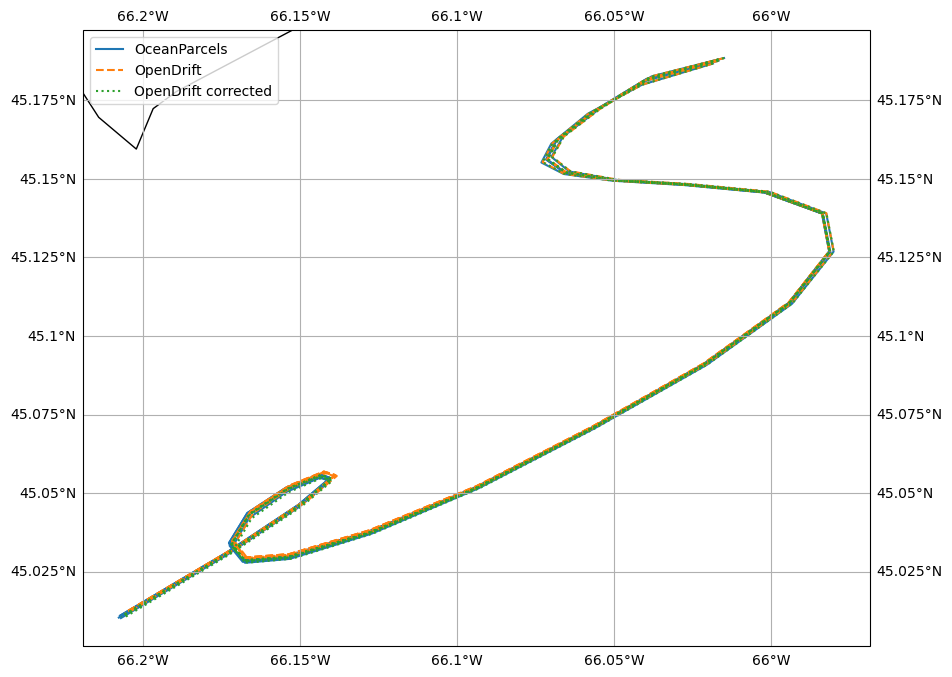

In [17]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1,projection=ccrs.PlateCarree())
count=0
for t in OP.trajectory.values:
    label='OceanParcels' if count==0 else '_nolabel'
    dsel=OP.sel(trajectory=t)
    ax.plot(dsel.lon.values, dsel.lat.values, 'C0', label=label,transform=ccrs.PlateCarree())
    count+=1
count=0
for t in OD.ntraj.values:
    label='OpenDrift' if count==0 else '_nolabel'
    dsel=OD.sel(ntraj=t)
    ax.plot(dsel.lon.values, dsel.lat.values, '--C1', label=label, transform=ccrs.PlateCarree())
    count+=1
count=0
for t in OD_corrected.ntraj.values:
    label='OpenDrift corrected' if count==0 else '_nolabel'
    dsel=OD_corrected.sel(ntraj=t)
    ax.plot(dsel.lon.values, dsel.lat.values, ':C2', label=label, transform=ccrs.PlateCarree())
    count+=1
ax.legend()
ax.coastlines()
ax.gridlines(draw_labels=True)

## Differences between OpenDrift and OceanParcels

* Look at the distances between pairs vs distance travelled
* only for corrected OpenDrift

In [18]:
from geopy.distance import distance

In [22]:
sep_orig = np.zeros_like(OD.lon.values)
sep_corrected = np.zeros_like(OD_corrected.lon.values)
OD_corrected_distance_travelled = np.zeros_like(OD_corrected.lon.values)
OD_distance_travelled = np.zeros_like(OD.lon.values)
OP_distance_travelled = np.zeros_like(OP.lon.values)
for i in range(sep.shape[0]):
    for t in range(sep.shape[1]):
        sep_orig[i,t] = distance((OD.lat.values[i,t],OD.lon.values[i,t]), 
                            (OP.lat.values[i,t],OP.lon.values[i,t])).meters
        sep_corrected[i,t] = distance((OD_corrected.lat.values[i,t],OD_corrected.lon.values[i,t]), 
                            (OP.lat.values[i,t],OP.lon.values[i,t])).meters
        if t >=1:
            OD_distance_travelled[i,t] = OD_distance_travelled[i,t-1] + \
                                            distance((OD.lat.values[i,t-1],OD.lon.values[i,t-1]), 
                                                     (OD.lat.values[i,t],OD.lon.values[i,t])).meters
            OD_corrected_distance_travelled[i,t] = OD_corrected_distance_travelled[i,t-1] + \
                                            distance((OD_corrected.lat.values[i,t-1],OD_corrected.lon.values[i,t-1]), 
                                                     (OD_corrected.lat.values[i,t],OD_corrected.lon.values[i,t])).meters
            OP_distance_travelled[i,t] = OP_distance_travelled[i,t-1] + \
                                            distance((OP.lat.values[i,t-1],OP.lon.values[i,t-1]), 
                                                     (OP.lat.values[i,t],OP.lon.values[i,t])).meters
        

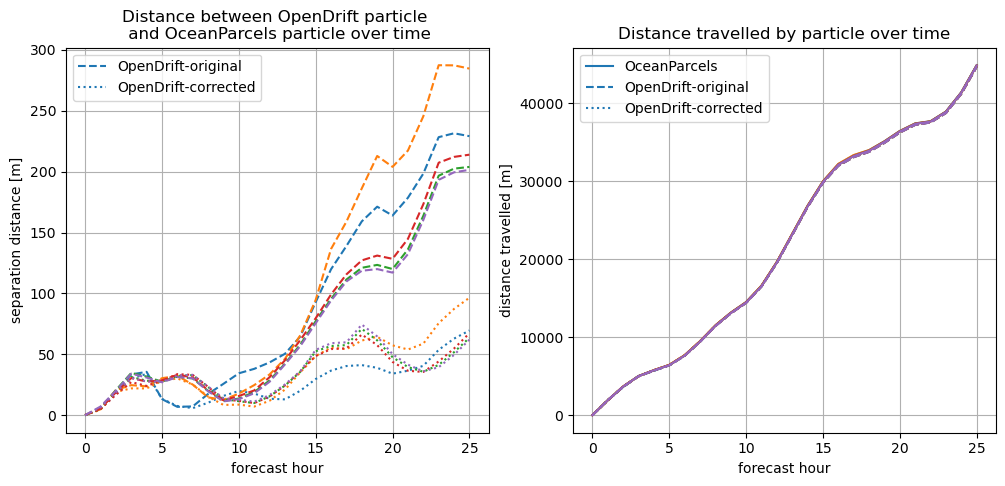

In [30]:
fig, axs = plt.subplots(1,2,figsize=(12,5))
count=0
label1='OceanParcels'
label2='OpenDrift-original'
label3='OpenDrift-corrected'
for i, c in zip(range(sep.shape[0]), ['C0', 'C1', 'C2', 'C3', 'C4']):
    if count!=0:
        label1='__nolabel'
        label2='__nolabel'
        label3='__nolabel'
    axs[0].plot(sep_orig[i,:],'--',color=c,label=label2)
    axs[0].plot(sep_corrected[i,:],':',color=c,label=label3)
    axs[1].plot(OP_distance_travelled[i,:],color=c,label=label1)
    axs[1].plot(OD_distance_travelled[i,:],'--',color=c, label=label2)
    axs[1].plot(OD_corrected_distance_travelled[i,:],':',color=c, label=label3)
    count+=1
axs[0].set_ylabel('separation distance [m]')
axs[0].set_xlabel('forecast hour')
axs[0].set_title('Distance between OpenDrift particle \n and OceanParcels particle over time')
axs[0].legend()
axs[0].grid()

axs[1].set_ylabel('distance travelled [m]')
axs[1].set_xlabel('forecast hour')
axs[1].set_title('Distance travelled by particle over time')
axs[1].legend()
axs[1].grid()

# Summary
* For this cases, the OpenDrift and OceanParcels trajectories are very similar, even with the rotation error.
* After 25 hours, the max separation distance is about 300m for the OpenDrift particles with the rotation error and 100m for the OpenDrift particles with the rotation error corrected. This is much smaller than the distance travelled by that particle which was nearly 45km. (about 0.05%).
* In conclusion, OpenDrift and OceanParcels perform similarly and the rotation error did not have a big impact on these drifters in the sj100 domain.